In [1]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 9.7 MB/s 
     |████████████████████████████████| 462 kB 40.6 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.2 MB 4.5 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 352 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 35.7 MB/s 
     |████████████████████████████████| 99 kB 8.8 MB/s 
     |████████████████████████████████| 636 kB 30.9 MB/s 
     |████████████████████████████████| 1.2 MB 7.2 MB/s 
     |████████████████████████████████| 47.8 MB 44 kB/s 
     |████████████████████████████████| 90 kB 6.7 MB/s 
     |████████████████████████████████| 237 kB 20.2 MB/s 


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

 
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks'

import preprocess
import fine_tunned_bert

!pip install reload
import importlib

importlib.reload(preprocess)

importlib.reload(fine_tunned_bert)

Mounted at /content/gdrive
/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 76 kB 3.8 MB/s 
  Created wheel for reload: filename=reload-0.9-py3-none-any.whl size=2880 sha256=09419788164b4f51503444a1e7c6dcadd67f16096c0fa5a56fb36c1a259d8625
  Stored in directory: /root/.cache/pip/wheels/f1/a2/ff/3f7b4879e081247a0e1381fd6699e86e0732ca0c365be41634
Successfully built reload
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'fine_tunned_bert' from '/content/gdrive/Shared drives/PFE/Colab Notebooks/fine_tunned_bert.py'>

In [4]:
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity'

/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity


In [5]:
import re 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from time import time

import pandas as pd
import numpy as np 

# Neural Net classifier 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [6]:
# model evaluation 
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from tensorflow.keras import metrics 
!pip install tensorflow-addons
import tensorflow_addons as tfa

from statistics import mean

from sklearn.metrics import confusion_matrix



In [7]:
import re 
# Functions for removing contractions 
contraction_dict = {"you'll":"you will", "we're": "we are","ain't": "are not","'s":" is","aren't": "are not", "won't": "would not", "don't": "do not", "isn't": "is not", "it's" : "it is"}
def expand_contractions(data,contractions_dict = contraction_dict):
  '''
    Expanding Contractions
    Arguments:
      data: textual dataset 
      contractions_dict : dictionanary containing the contractions and their replacements 
    Returns :
      clean_data : textual dataset where contractions are expanded
  '''
  # Regular expression for finding contractions
  contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
  def replace(match):
      return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, data)

In [8]:
import string 

In [9]:
# import and prep dataset 
# import the advertising dataset 
# Each ad has a binary label 0 for commercial and 1 for informational ads 
df = preprocess.get_data('./data/revised/training_scarcity_18k.csv', columns_to_drop= False )

df['ad'] = df['ad'].str.strip().str.lower() 

# Expand contractions 
df['ad'] = df['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df['ad'] =  df['ad'].str.translate(str.maketrans('','',string.punctuation))

df=df.sample(frac=1)

clean_data = df['ad']

df['clean_data'] = clean_data



df.head()

,ad,scarcity,clean_data
17444,of social security recipients receive less mon...,0,of social security recipients receive less mon...
13783,thank you to all of the front line workers who...,0,thank you to all of the front line workers who...
5310,we broke the record for the biggest launch ra...,1,we broke the record for the biggest launch ra...
16234,should council of dc vote to keep housing affo...,0,should council of dc vote to keep housing affo...
17332,alert super tuesday is almost here\nwe need to...,0,alert super tuesday is almost here\nwe need to...


In [10]:
bert_model_name='small_bert/bert_en_uncased_L-4_H-512_A-8'

In [11]:
# build test and training datasets 
train_data, val_data, test_data = preprocess.eval_train_split(df['clean_data'], df['scarcity'] , test_size = 0.2, validation = True)
cleaned_train, y_train,cleaned_val, y_val, cleaned_test, y_test = train_data[0], train_data[1],val_data[0], val_data[1], test_data[0], test_data[1]

In [12]:
train_data = tf.data.Dataset.from_tensor_slices(  (cleaned_train,y_train) ).batch(32)
val_data = tf.data.Dataset.from_tensor_slices( (cleaned_val,y_val) ).batch(32)
test_data = tf.data.Dataset.from_tensor_slices( (cleaned_test,y_test) ).batch(32)
# create the fine_tunned_model
bert_model = fine_tunned_bert.create_fine_tunned_bert(train_data,bert_model_name=bert_model_name)
# training the model
history = bert_model.fit(x=train_data,epochs =5,validation_data = val_data,verbose=False)
# evaluation 
scores = bert_model.evaluate(test_data)
print("-----------------------------------------")
predictions=bert_model.predict(cleaned_test)
results = (predictions>0.5)*1
tn, fp, fn, tp = confusion_matrix(y_test,results).ravel()
print("Fold cofusion matrix")
print((tn, fp, fn, tp))
print("-----------------------------------------")


113/113 [==============================] - 21s 187ms/step - loss: 0.1405 - accuracy: 0.9622 - precision: 0.9646 - recall: 0.9592 - auc: 0.9887
-----------------------------------------
Fold cofusion matrix
(1747, 63, 73, 1717)
-----------------------------------------


In [13]:
# model evaluation 
scores = bert_model.evaluate(test_data)
print("Accuracy: %.2f%%" % (scores[1]*100))

113/113 [==============================] - 21s 187ms/step - loss: 0.1405 - accuracy: 0.9622 - precision: 0.9646 - recall: 0.9592 - auc: 0.9887
Accuracy: 96.22%


In [14]:

from sklearn import metrics

In [15]:
print(metrics.classification_report(y_test, results, target_names=[ 'no-scarcity', 'scarcity']))

              precision    recall  f1-score   support

 no-scarcity       0.96      0.97      0.96      1810
    scarcity       0.96      0.96      0.96      1790

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [16]:
!pip install scikit-plot
import scikitplot as skplt

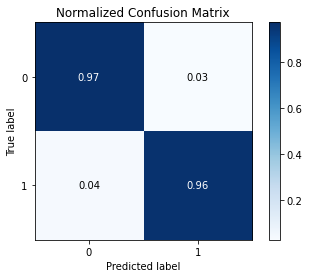

In [17]:

skplt.metrics.plot_confusion_matrix(y_test, results , normalize=True)
plt.show()

In [18]:
save = pd.read_csv('data/revised/test_scarcity_4k.csv')
save=save.sample(frac=1)
save['ad'] = save['ad'].str.strip().str.lower() 

# Expand contractions 
save['ad'] = save['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
save['ad'] =  save['ad'].str.translate(str.maketrans('','',string.punctuation))



test_data = tf.data.Dataset.from_tensor_slices( (save['ad'],save['scarcity']) ).batch(32)
# model evaluation 
scores = bert_model.evaluate(test_data)
print(scores)

156/156 [==============================] - 40s 256ms/step - loss: 0.1691 - accuracy: 0.9598 - precision: 0.9554 - recall: 0.9647 - auc: 0.9833
[0.16912831366062164, 0.9598393440246582, 0.9554494619369507, 0.9646586179733276, 0.9832942485809326]


In [19]:
predictions=bert_model.predict(save['ad'])
results = (predictions>0.5)*1


print(metrics.classification_report(save['scarcity'], results, target_names=[ 'no-scarcity', 'scarcity']))

              precision    recall  f1-score   support

 no-scarcity       0.96      0.96      0.96      2490
    scarcity       0.96      0.96      0.96      2490

    accuracy                           0.96      4980
   macro avg       0.96      0.96      0.96      4980
weighted avg       0.96      0.96      0.96      4980



In [20]:


save = pd.read_csv('data/sample_130.csv')

save=save.sample(frac=1)


save.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
save['ad'] = save['ad'].str.strip().str.lower() 

# Expand contractions 
save['ad'] = save['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
save['ad'] =  save['ad'].str.translate(str.maketrans('','',string.punctuation))

test_data = tf.data.Dataset.from_tensor_slices( (save['ad'],save['scarcity']) ).batch(32)
# model evaluation 
scores = bert_model.evaluate(test_data)
print("Accuracy: %.2f%%" % (scores[1]*100))



4/4 [==============================] - 1s 187ms/step - loss: 3.0805 - accuracy: 0.5873 - precision: 0.6271 - recall: 0.5522 - auc: 0.5841
Accuracy: 58.73%


confusion matrix:
[[37 22]
 [30 37]]



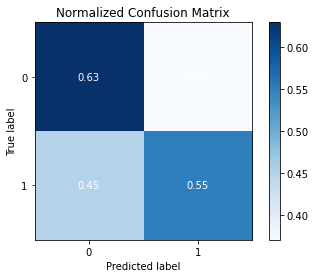

In [21]:
from sklearn import metrics
pred_ =  bert_model.predict(save['ad'])
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(save['scarcity'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['scarcity'], save['predicted'], normalize=True)
plt.show()

In [22]:
print(metrics.classification_report(save['scarcity'], save['predicted'], target_names=[ 'no-scarcity', 'scarcity']))

              precision    recall  f1-score   support

 no-scarcity       0.55      0.63      0.59        59
    scarcity       0.63      0.55      0.59        67

    accuracy                           0.59       126
   macro avg       0.59      0.59      0.59       126
weighted avg       0.59      0.59      0.59       126

